In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2

In [2]:
include("../../util.j")

colnorm (generic function with 1 method)

In [3]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
#using Pkg
#Pkg.add("ProgressMeter");

In [5]:
@load "../data/sim2data.jld";

In [ ]:
# priors #
#μΛ = fill(0.0, K, q); VΛ =[[100.0 0.0]; [0.0 100.0]];
#νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];
ϕU = 300 / sqrt(2); ϕL = 3 / sqrt(2);

#test turning parameter ...

using RCall 
x_1 = X_ord[S1_ind, :]; x_2 = X_ord[S2_ind, :]; y_1 = Y_ord[S1_ind, 1]; y_2 = Y_ord[S2_ind, 2]; 
coords_1 = transpose(coords_ord[:, S1_ind]); coords_2 = transpose(coords_ord[:, S2_ind]); 
P1_ind = setdiff(1:N, S1_ind); P2_ind = setdiff(1:N, S2_ind); 
coords_ord_P1 = transpose(coords_ord[:, P1_ind]) 
coords_ord_P2 = transpose(coords_ord[:, P2_ind]) 
@rput x_1 x_2 y_1 y_2 X_ord; 
@rput q p K; @rput ϕU ϕL; 
@rput coords_1 coords_2 coords_ord_P1 coords_ord_P2 P1_ind P2_ind

R""" 
library(spBayes) 
set.seed(1) 
n.samples <- 1000 
A.starting <- diag(1, q)[lower.tri(diag(1,q), TRUE)] 
starting <- list("phi"=rep(3/0.5,q), "A"=A.starting, "Psi"=rep(0.5,q)) 
tuning <- list("phi"=rep(0.1,q), "A"=rep(0.01,length(A.starting)), "Psi"=rep(0.01,q)) 
priors <- list("beta.Flat", "phi.Unif"=list(rep(ϕL, q), rep(ϕU, q)), 
               "K.IW"=list(q + 1, diag(1.0, q)), "Psi.ig"=list(rep(2 , q), rep(0.2,q)))

m.1 <- spMisalignLM(list(y_1~x_1-1, y_2~x_2-1), coords = list(coords_1, coords_2), 
                   starting=starting, tuning=tuning, priors=priors, n.samples=n.samples, 
                   cov.model="exponential", n.report=100) 
tt_data <- m.1p.theta.samplesprint(dimnames(m.1

p.theta.samples)) """ 
@rget tt_data

tt_pos_sam = Array{Float64, 3}(undef, size(tt_data)[1], size(tt_data)[2], 1); 
tt_pos_sam[:, :, 1] = hcat(tt_data[:, 1], tt_data[:, 2], tt_data[:, 3], tt_data[:, 4], 
    tt_data[:, 5], tt_data[:, 6], tt_data[:, 7]); tt_chain = Chains(tt_pos_sam); ptt = plot(tt_chain)


In [ ]:
using RCall
x_1 = X_ord[S1_ind, :]; x_2 = X_ord[S2_ind, :]; 
y_1 = Y_ord[S1_ind, 1]; y_2 = Y_ord[S2_ind, 2]; 
coords_1 = transpose(coords_ord[:, S1_ind]); coords_2 = transpose(coords_ord[:, S2_ind]); 
P1_ind = setdiff(1:N, S1_ind);
P2_ind = setdiff(1:N, S2_ind);
coords_ord_P1 = transpose(coords_ord[:, P1_ind])
coords_ord_P2 = transpose(coords_ord[:, P2_ind])
@rput x_1 x_2 y_1 y_2 X_ord;
@rput q p K;
@rput ϕU ϕL;
@rput coords_1 coords_2 coords_ord_P1 coords_ord_P2 P1_ind P2_ind


R"""
library(spBayes)
set.seed(1)
n.samples <- 20000
A.starting <- diag(1, q)[lower.tri(diag(1,q), TRUE)]
starting <- list("phi"=rep(3/0.5,q), "A"=A.starting, "Psi"=rep(1,q))
tuning <- list("phi"=rep(0.1,q), "A"=rep(0.01,length(A.starting)), "Psi"=rep(0.01,q))
priors <- list("beta.Flat", "phi.Unif"=list(rep(ϕL, q), rep(ϕU, q)),
               "K.IW"=list(q + 1, diag(1.0, q)), "Psi.ig"=list(rep(2 , q), rep(0.2,q)))
t <- proc.time()
m.1 <- spMisalignLM(list(y_1~x_1-1, y_2~x_2-1), 
                    coords = list(coords_1, coords_2), starting=starting, tuning=tuning, priors=priors,
                    n.samples=n.samples, cov.model="exponential", n.report=100)
burn.in <- 0.75*n.samples

m.1 <- spRecover(m.1, start = burn.in)

print(proc.time()-t)

print(round(summary(m.1$p.theta.recover.samples)$quantiles[,c(3,1,5)],2))
print(round(summary(m.1$p.beta.recover.samples)$quantiles[,c(3,1,5)],2))
theta_samples_all <- m.1$p.theta.samples
theta_samples <- m.1$p.theta.recover.samples
beta_samples <- m.1$p.beta.recover.samples
w_samples <- m.1$p.w.recover.samples
cat(m.1$run.time)

t <- proc.time()
# predict for all locations, i.e., observed and not observed
out <- spPredict(m.1, start = burn.in, thin = 2, pred.covars = list(X_ord[P1_ind, ], X_ord[P2_ind, ]),
                pred.coords = list(coords_ord_P1, coords_ord_P2))
cat("\n", proc.time() - t)
mean_quants <- function(x){c(mean(x), quantile(x, prob=c(0.5, 0.025, 0.975)))}
yhat <- apply(out$p.y.predictive.samples, 1, mean_quants)
m1_w_hat <- summary(mcmc(t(m.1$p.w.recover.samples)))$quantiles[,c(3,1,5)]


# size for the mapping of w               
width <- 360*3
height <- 360*3
pointsize <- 16

png(paste("../../pics/MCMC_sim2_spBayes.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
plot(m.1$p.theta.samples)
dev.off()

"""
@rget theta_samples_all
@rget theta_samples
@rget beta_samples
@rget yhat
@rget m1_w_hat
@rget w_samples

┌ Warning: Package RCall does not have AxisArrays in its dependencies:
│ - If you have RCall checked out for development and have
│   added AxisArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RCall
│ Loading AxisArrays into RCall from project dependency, future warnings for RCall are suppressed.
└ @ nothing nothing:840
┌ Warning: RCall.jl: Loading required package: coda
│ Loading required package: magic
│ Loading required package: abind
│ Loading required package: Formula
│ Loading required package: Matrix
└ @ RCall /home/lu/.julia/packages/RCall/ffM0W/src/io.jl:113


----------------------------------------
	General model description
----------------------------------------
Model fit with 2 outcome variables.

Number of observations within each outcome: 1000 1000 

Number of covariates for each outcome (including intercept if specified): 2 2 

Total number of observations: 2000

Total number of covariates (including intercept if specified): 4

Using the exponential spatial correlation model.

Number of MCMC samples 20000.

Priors and hyperpriors:
	beta flat.

	K IW hyperpriors df=3.00000, S=
	1.000	0.000	
	0.000	1.000	

	Diag(Psi) IG hyperpriors
		parameter	shape	scale
		Psi[1,1]	2.0	0.20
		Psi[2,2]	2.0	0.20

	phi Unif hyperpriors
		parameter	a	b
		phi[1]		2.12132	212.13203
		phi[2]		2.12132	212.13203

-------------------------------------------------
		Sampling
-------------------------------------------------
Sampled: 100 of 20000, 0.50%
Report interval Metrop. Acceptance rate: 18.00%
Overall Metrop. Acceptance rate: 18.00%
----------------------

In [ ]:
ω_incp_samples = Array{Float64, 2}(undef, size(w_samples));
N_sam = size(w_samples)[2]
for i in 1:N_sam
    for j in 1:q
        ω_incp_samples[(1 + (j - 1) * N1):(j * N1), i] = 
        w_samples[(1 + (j - 1) * N1):(j * N1), i] .+ beta_samples[i, 1 + (j - 1) * q]
    end
end

ω_incp_qt = Array{Float64, 3}(undef, N1, q, 3);
for j in 1:q
    for i in 1:N1
        ω_incp_qt[i, j, :] = quantile(ω_incp_samples[i + (j - 1) * N1, :], [0.025, 0.5, 0.975])
    end
end

In [ ]:
@save "../results/LMC_misalign_spbayes.jld" theta_samples beta_samples yhat ω_incp_samples w_samples ω_incp_qt theta_samples_all

# MCMC Chain check

In [46]:
@load "../results/LMC_misalign_spbayes.jld"

4-element Array{Symbol,1}:
 :theta_samples
 :beta_samples 
 :yhat         
 :m1_w_hat     

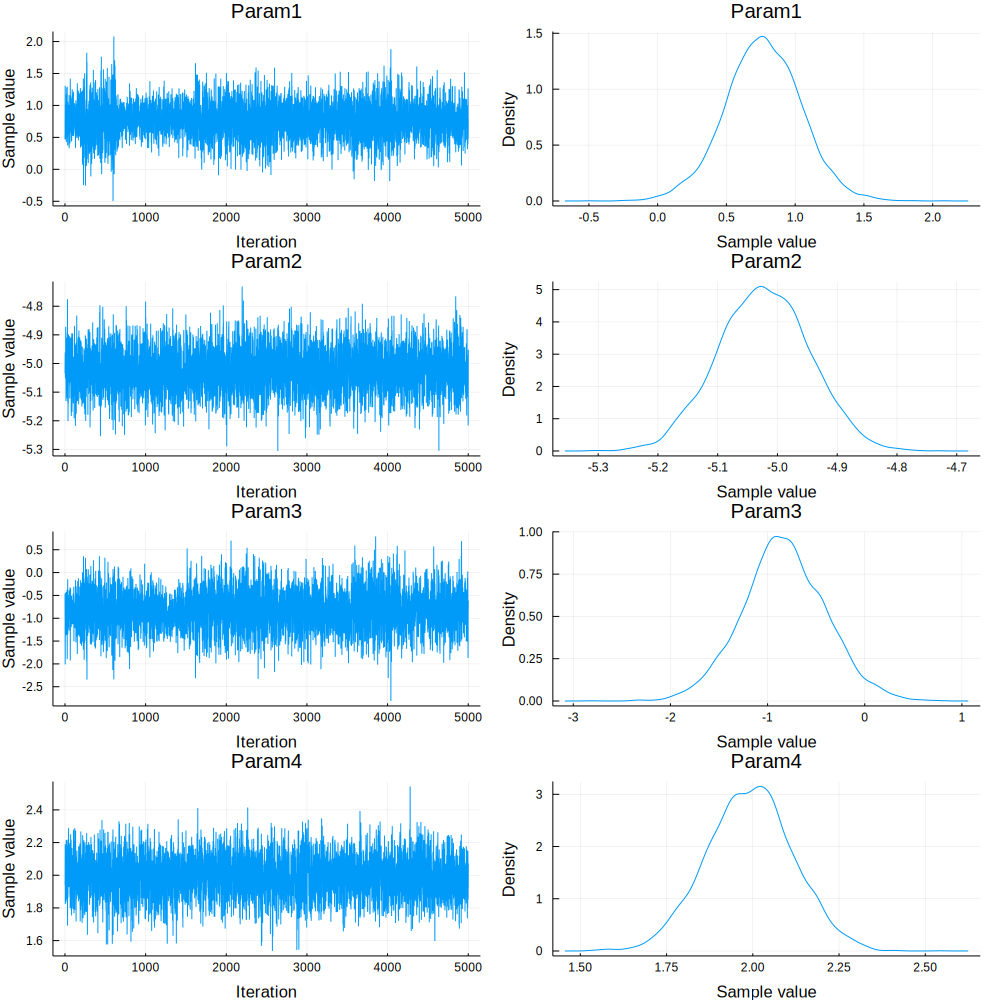

In [47]:
β_pos_sam = Array{Float64, 3}(undef, size(beta_samples)[1], p * q, 1);
β_pos_sam[:, :, 1] = hcat(beta_samples[:, 1], beta_samples[:, 2], beta_samples[:, 3], beta_samples[:, 4]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

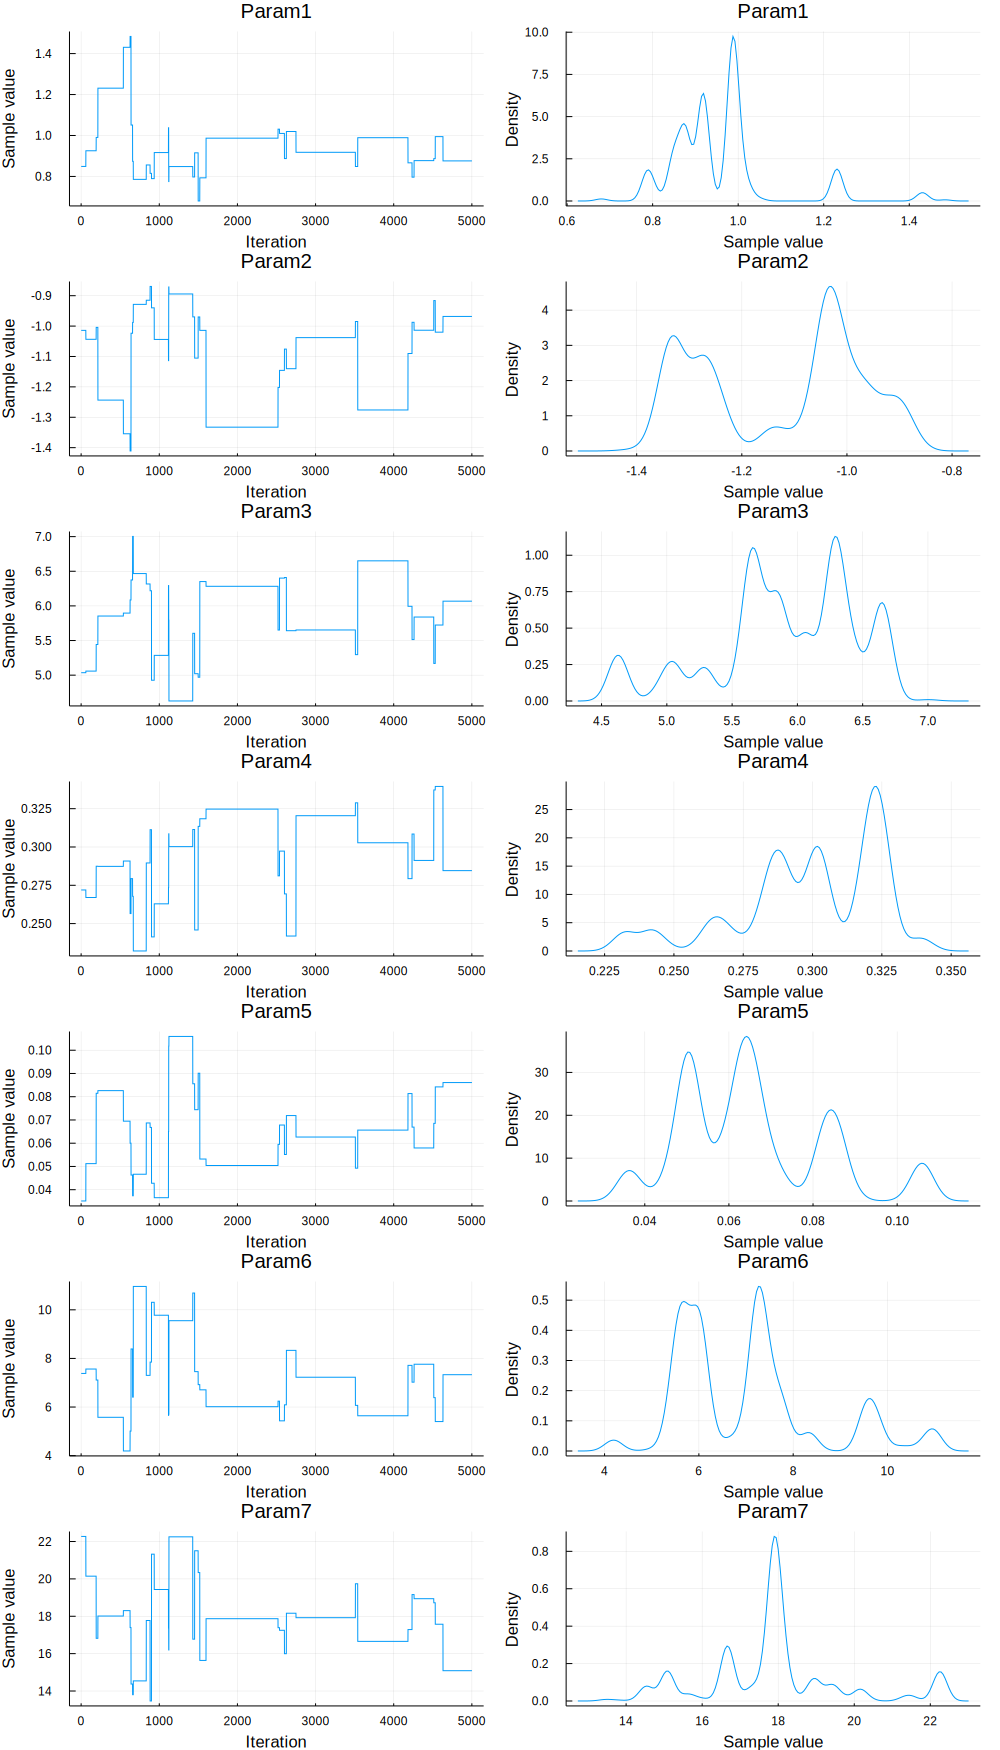

In [48]:
Λ_pos_sam = Array{Float64, 3}(undef, size(theta_samples)[1], size(theta_samples)[2], 1);
Λ_pos_sam[:, :, 1] = hcat(theta_samples[:, 1], theta_samples[:, 2], theta_samples[:, 3], theta_samples[:, 4],
    theta_samples[:, 5], theta_samples[:, 6], theta_samples[:, 7]);
Λ_chain = Chains(Λ_pos_sam);
pΛ = plot(Λ_chain)

In [ ]:
# check the variance covariance across latent process
cov_pos = Array{Float64, 3}(undef, q, q, N_sam);
for i in 1:N_sam
    cov_pos[:, :, i] = cov([w_samples[1:N1, i] w_samples[(1 + N1):(2 * N1), i]])
end   
# ω_incp_obs_pos_sam[:, :, i]
cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
cov_pos_sam[:, :, 1] = hcat(cov_pos[1, 1, :], cov_pos[1, 2, :], 
    cov_pos[2, 1, :], cov_pos[2, 2, :]);
cov_pos_chain = Chains(cov_pos_sam);
pcov = plot(cov_pos_chain)

# Posterior Inference 

In [ ]:
# count the covarage of 95% CI for prediction#
Nm = N - N1
count = fill(0.0, 2);
SPE = 0.0

for i in 1:Nm
    count[1] = count[1] + 
            ((yhat[3, i] < Y_ord[P1_ind[i], 1]) && 
                (yhat[4, i] > Y_ord[P1_ind[i], 1]))
    SPE = SPE + (yhat[1, i] - Y_ord[P1_ind[i], 1])^2
end

for i in 1:Nm
    count[2] = count[2] + 
            ((yhat[3, i + Nm] < Y_ord[P2_ind[i], 2]) && 
                (yhat[4, i + Nm] > Y_ord[P2_ind[i], 2]))
    SPE = SPE + (yhat[1, i + Nm] - Y_ord[P2_ind[i], 2])^2
end

count

In [ ]:
count ./ 200

In [ ]:
sqrt(SPE / 400)

In [16]:
# count the covarage of 95% CI #
count = fill(0.0, 2);
for j in 1:q
    for i in 1:N1
        if j == 1
            count[1] = count[1] + 
                ((ω_incp_qt[i, j, 1 ] < ω_incp_obs[S1_ind[i], j]) && 
                (ω_incp_qt[i, j, 3 ] > ω_incp_obs[S1_ind[i], j]))
        else
            count[2] = count[2] + 
                ((ω_incp_qt[i, j, 1] < ω_incp_obs[S2_ind[i], j]) && 
                (ω_incp_qt[i, j, 3] > ω_incp_obs[S2_ind[i], j]))
        end
    end
end
count ./ N

2-element Array{Float64,1}:
 1161.0
 1163.0

In [17]:
# count the covarage of 95% CI of w#
count = fill(0.0, 2);
for j in 1:q
    for i in 1:N1
        if j == 1
            count[1] = count[1] + 
                ((m1_w_hat[i, 2 ] < ω_ord[S1_ind[i], j]) && 
                (m1_w_hat[i, 3 ] > ω_ord[S1_ind[i], j]))
        else
            count[2] = count[2] + 
                ((m1_w_hat[i + (j - 1) * N1, 2] < ω_ord[S2_ind[i], j]) && 
                (m1_w_hat[i + (j - 1) * N1, 3] > ω_ord[S2_ind[i], j]))
        end
    end
end
count ./ N

2-element Array{Float64,1}:
 0.9675            
 0.9691666666666666

In [ ]:
N1

ω_incp_obs_pos_sam = Array{Float64, 3}(undef, n, q, N_sam); 
lll = fill(1.0, (n, 1)); 
for i in 1:N_sam 
    ω_incp_obs_pos_sam[:, :, i] = F_sam[:, :, i] γ_sam[(p + 1):(p + K), :, i + 1] + lll transpose(γ_sam[1, :, i + 1]); 
end 
truncindex = 1;#Integer(trunc(N_sam / 2)); 
ω_incp_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex + 1, 3, 1); 
ω_incp_pos_sam[:, :, 1] = hcat(ω_incp_obs_pos_sam[1, 1, truncindex:N_sam], 
    ω_incp_obs_pos_sam[1, 2, truncindex:N_sam], ω_incp_obs_pos_sam[200, 1, truncindex:N_sam]); 
ω_incp_chain = Chains(ω_incp_pos_sam); pΣ = plot(ω_incp_chain)


In [ ]:
# check the variance covariance across latent process # need the sample of w ...
#cov_pos = Array{Float64, 3}(undef, q, q, size(theta_samples)[1]);
#for i in 1:size(theta_samples)[1]
#    L = [theta_samples[i, 1] 0
#        
#    cov_pos[:, :, i] = cov(F_sam[:, :, i] * γ_sam[(p + 1):(p + K), :, i + 1])
#end   
# ω_incp_obs_pos_sam[:, :, i]
#cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
#cov_pos_sam[:, :, 1] = hcat(cov_pos[1, 1, :], cov_pos[1, 2, :], 
#    cov_pos[2, 1, :], cov_pos[2, 2, :]);
#cov_pos_chain = Chains(cov_pos_sam);
#pcov = plot(cov_pos_chain)

In [ ]:
covω = cov(ω_ord[S, :])

In [28]:
summary_table = Array{Float64, 2}(undef, 9, 5);
summary_table[1, :] = vcat(β[2, 1], mean(beta_samples[:, 2]),
    quantile(beta_samples[:, 2], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[2, 2], mean(beta_samples[:, 4]),
    quantile(beta_samples[:, 4], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(Σ[1, 1], mean(theta_samples[:, 4]),
    quantile(theta_samples[:, 4], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(Σ[2, 2], mean(theta_samples[:, 5]),
    quantile(theta_samples[:, 5], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat(covω[1, 1], mean(cov_pos_sam[:, 1, 1]),
    quantile(cov_pos_sam[:, 1, 1], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(covω[1, 2], mean(cov_pos_sam[:, 2, 1]),
    quantile(cov_pos_sam[:, 2, 1], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(covω[2, 2], mean(cov_pos_sam[:, 4, 1]),
    quantile(cov_pos_sam[:, 4, 1], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat(ϕ1, mean(theta_samples[:, 6]),
    quantile(theta_samples[:, 6], [0.5, 0.025, 0.975]));
summary_table[9, :] = vcat(ϕ2, mean(theta_samples[:, 7]),
    quantile(theta_samples[:, 7], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3);
rnames = ["β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[2, 2]", "cov(ω)[1, 1]", 
    "cov(ω)[1, 2]", "cov(ω)[2, 2]", "ϕ1", "ϕ2"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

[27.0, 29.0][0.931034, 1.0]

2-element Array{Float64,1}:
 193.0
 189.0